---
  Authors: Connor Amato and Sho Takeshita

  Title: Enzyme Stability Regression
---
Novozymes Enzyme Stability Prediction Kaggle Competition

## Motivation
In industry, enzymes replace chemicals and accelerate production processes. Understanding enzyme stability is a problem in biotechnology, which could help reduce waste, lower costs, and increase production speed.

## Overview
Our goal is to predict the thermostability of proteins, which is measured by their melting points, after single point amino acid mutations and deletions. The relationship between protein type and thermostability is not straightforward, but the amount of disorder (e.g. mutation) in a protein sequence is the main factor according to this publication supplied by the competition: https://www.nature.com/articles/s41592-020-0801-4.
The competition uses Spearman correlation coefficient as the metric for performance.  

## The Dataset
This kaggle competition gives us a training and a test dataset. The dataset contains around 31 thousand records of the variant for one enzyme, sourced from an attempt to atlas the thermal stability of proteins across different types of proteins. The datasets contain for each protein their sequence id (identifies each protein variant), protein sequence (amino acid sequence), pH at which the stability was measured, thermostability (melting point), and a link to the source of the data. The training set includes normal sequences as well as sequences with single or multiple mutations. The submission to the competition is a csv file with the test set along with the classified thermostability. This is a continuous data point so we will be applying some sort of regression model.
## Reading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #Imported basic libraries
import seaborn as sns
import sklearn as sk

In [2]:
df = pd.read_csv("train.csv")
df.head(5)

seq_id                                   protein_sequence   pH  \
0       0  AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0   
1       1  AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0   
2       2  AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0   
3       3  AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...  7.0   
4       4  AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...  7.0   

                         data_source    tm  
0  doi.org/10.1038/s41592-020-0801-4  75.7  
1  doi.org/10.1038/s41592-020-0801-4  50.5  
2  doi.org/10.1038/s41592-020-0801-4  40.5  
3  doi.org/10.1038/s41592-020-0801-4  47.2  
4  doi.org/10.1038/s41592-020-0801-4  49.5

In [3]:
df = df.drop("data_source", axis = 1) #This column is not useful to classification
print(len(df[df["protein_sequence"].isnull()]),
len(df[df["tm"].isnull()]),
len(df[df["pH"].isnull()])) 
# Each remaining column is perfect except for the 286 missing pH values

0 0 286


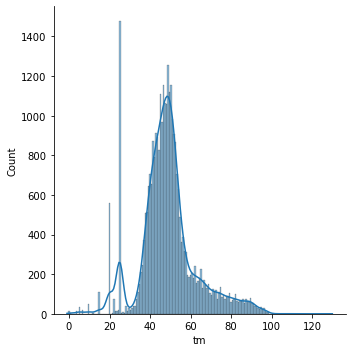

In [4]:
sns.displot(df['tm'], kde=True) # Let's see the distribution of the classifications 
#(tm is the enzyme melting point and is a measure of stability)

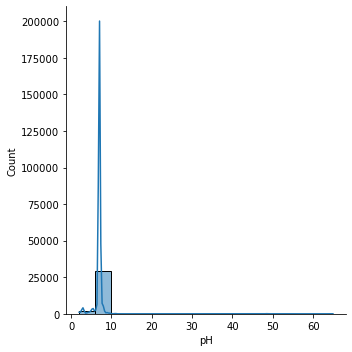

In [5]:
sns.displot(df['pH'], kde=True)

In [6]:
print(len(df), " Total Rows vs ", len(df["protein_sequence"].unique()), " Unique Sequences")

31390  Total Rows vs  28981  Unique Sequences


coorelation: -0.058987150915936856


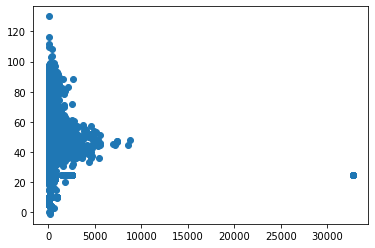

In [7]:
plt.scatter(df["protein_sequence"].apply(lambda x : len(x)), df["tm"])
print("coorelation: " + str(df["tm"].corr(df["protein_sequence"].apply(lambda x : len(x))))) 
# looks like no relation, we can ignore the length of sequences

In [8]:
# This is the base wild type sequence provided in the description of the competition

base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
len(base)

221

## Parsing
The protein sequence feature is almost entirely made of of unique values, so we need to parse this into multiple more useful features. To do this, we will employ the PyRosseta library, which supplies funcitonality for dealing with molecular biology information. 

In [9]:
#!pip install pyrosetta
#import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()
import pyrosetta; pyrosetta.init()


PyRosetta-4 2022 [Rosetta PyRosetta4.Release.python39.linux 2022.49+release.201d7639f91f369d58b1adf514f3febaf6154c58 2022-12-07T16:15:33] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python39.linux r337 2022.49+release.201d763 201d7639f91f369d58b1adf514f3febaf6154c58 http://www.pyrosetta.org 2022-12-07T16:15:33
core.init: command: PyRosetta -ex1 -ex2aro -database /home/sho/anaconda3/lib/python3.9/site-packages/pyrosetta-2022.49+release.201d763-py3.9-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-913028262 seed_offset=0 real_seed=-913028262
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=-913028262 RG_type=mt19937


In [10]:
# Generates residue (number of amino acids in the sequence)
from pyrosetta import *
init()
base_pose = pose_from_sequence(base , 'fa_standard')
print("base residue: ", base_pose.total_residue())


PyRosetta-4 2022 [Rosetta PyRosetta4.Release.python39.linux 2022.49+release.201d7639f91f369d58b1adf514f3febaf6154c58 2022-12-07T16:15:33] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python39.linux r337 2022.49+release.201d763 201d7639f91f369d58b1adf514f3febaf6154c58 http://www.pyrosetta.org 2022-12-07T16:15:33
core.init: command: PyRosetta -ex1 -ex2aro -database /home/sho/anaconda3/lib/python3.9/site-packages/pyrosetta-2022.49+release.201d763-py3.9-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=3612179 seed_offset=0 real_seed=3612179
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=3612179 RG_type=mt19937
core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard re

Using Rosetta's scoring, let's get the energy balance and number of atoms from each amino acid present in the base sequence. This will be useful later for numeralizing the mutations. Lower energies are more stable.

In [11]:
score_func = get_score_function(True) # Used for scoring amino acids in pyRosetta
energy_dict = {}
atoms_dict = {}
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
for aa in amino_acids:
    pose = pose_from_sequence(str(aa), 'fa_standard') 
    energy_dict[aa] = score_func(pose)
    atoms_dict[aa] = pose.total_atoms()
    print(str(aa) + " - energy: " + str(energy_dict[aa]) + ", # atoms: " + str(atoms_dict[aa]))

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
basic.io.database: Database file opened: scoring/score_functions/rama/fd/

## Grouping Sequences
The train data contains thousands of sequences that are not grouped properly.
To assign an original wildtype sequence to the training data, we will emply the use of the train wildtype groups csv file containing all wiltypes present in the training data. 

In [12]:
wildtype_groups = pd.read_csv("train_wildtype_groups.csv") #https://www.kaggle.com/datasets/shlomoron/train-wildtypes-af?select=train_wildtype_groups.csv 
wildtypes = wildtype_groups["wildtype"].unique()
len(wildtypes) # There are 78 unique wildtypes in the training data

78

To group each sequence into a wildtype group, we need to emply a string difference algorithm. We have chosen the levenshtein distance because we do not care about what place each character is in, just the amount of additions or deletions.

In [13]:

from Levenshtein import distance as levenshtein_distance
delta = 6
df["wildtype"] = -1
for idx in range(len(wildtypes)):
  wt = wildtypes[idx]
  def assign_wildtype(seq, prev):
    #seq = row.protein_sequence
    length = len(seq)
    if ((length > (len(wt) - delta)) or (length < (len(wt) + delta))) and levenshtein_distance(wt, seq) < 20:
      return idx
    else:
      return prev
  new_wts = []
  for row in df.iterrows():
    new_wts.append(assign_wildtype(row[1]["protein_sequence"], row[1]["wildtype"]))
  df["wildtype"] = new_wts
df["wildtype"].value_counts()

-1     25619
 0       816
 1       783
 3       308
 2       211
       ...  
 75        6
 76        6
 74        6
 73        6
 77        5
Name: wildtype, Length: 78, dtype: int64

### Energy Calculations
Using the dictionaries for each amino acid and their energy and number of atoms, we will calculate the 

In [14]:
mutations = []
energy_changes = []
for row in df.iterrows():
  seq = row[1]["protein_sequence"]
  wt = wildtypes[row[1]["wildtype"]]
  diff = ""
  flag = False
  count = 0
  muts = []
  wts = []
  for i in range(min(len(wt), len(seq))):
    if (wt[i] != seq[i]):
      count = count + 1
      if not flag:
        muts.append(seq[i])
        wts.append(wt[i])
        diff = diff + str(i) + " "
        flag = True
      diff = diff + seq[i]
    else:
      if flag:
        diff = diff + " - "
        flag = False
  print(count)
  print(diff)
  energy_change = 0
  for j in range(len(muts)):
    emut = energy_dict[muts[j]]
    ewt = energy_dict[wts[j]]
    nmut = atoms_dict[muts[j]]
    nwt = atoms_dict[wts[j]]
    e_bar = (emut/nmut - ewt/nwt) / (ewt/nwt) # Formula from study
    energy_change = energy_change + e_bar
  mutations.append(count)
  energy_changes.append(energy_change)
df["total_mutations"] = mutations
df["energy"] = energy_changes


145
0 A - 2 AA - 5 AAALA - 12 GEAPEV - 19 DI - 22 LPAGWRQPF - 32 VFRLE - 38 KGDGVLVGMIKDAGDDPDVTHGAEIQAFVRFASEDRLEGGEGVGVVTKPGLG - 91 PVGEPAI - 99 PVPRRMIWEAVREVTERPLAVTIAIPGGEELAKKTLNPRL - 140 ILGGLSVLGTTGVVKP
143
0 A - 2 ADGEPLHNEEERAGAGQV - 21 RSL - 25 QESE - 30 Q - 32 TGSRP - 38 RRR - 42 LG - 45 RLQAQRRAQRVAWEDGDENV - 66 QTVIPAQEEEGIEKPAEVHPTGKIGAK - 94 LRKLEEKQARKAQREAEEAEREERKRLESQREAEW - 130 KEEERLRLKEEQKEEEERK - 150 QE - 153 QAR
147
0 A - 2 AFSTPRATSYRI - 15 SSAGS - 21 STRADAPQVR - 32 LHTTRDLLAKDYYATLGVAKNA - 55 GKDIKKAYY - 65 LAK - 69 YHPDTNK - 77 DPDAGRKFQEVSEAYEVLSDEQKRREYDTYGQ - 110 AENIGRQGGGFPGGGAGGFGPEGFSQSWQFRSSIDPEELFRKIFGE
142
0 A - 2 ASGLRTAIPAQP - 15 RH - 18 LQPAPR - 25 C - 27 RPFGLLSVRAGSARR - 43 GLLQPPVPCA - 54 GCGALHTEGDKAFVEFLTDEIK - 77 EKKIQKHKSLPKMSGDWELEV - 99 GTEAKLLRKVAGEKI - 115 VTFNIN - 122 SIPP - 127 FDG - 131 EEPSQGQKAEEQE - 145 ELTSTPNFVVE
146
0 A - 2 AT - 6 GP - 9 RQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNC - 45 AY - 48 EP - 51 PNIEWKKDGTFLNLESDDRRQLLPDGS - 7

In [15]:
df[df["wildtype"] != -1].head(10)

seq_id                                   protein_sequence    pH    tm  \
266     266  AKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...   7.5  58.0   
972     972  DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...   7.0  45.2   
973     973  DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...  48.4   7.0   
974     974  DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...   7.0  48.0   
981     981  DVSGTVCLSALPPEATDTLNLIASDGPFPFSQDGVVFQNRESVLPT...   7.0  25.0   
982     982  DVSGTVCLSALPPEATDTLNLIASDGPFPYSQAGVVFQNRESVLPT...   7.0  31.8   
983     983  DVSGTVCLSALPPEATDTLNLIASDGPFPYSQAGVVFQNRESVLPT...   7.0  52.6   
984     984  DVSGTVCLSALPPEATDTLNLIASDGPFPYSQAGVVFQNRESVLPT...   7.0  25.0   
985     985  DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVTFQNRESVLPT...   7.0  43.8   
986     986  DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVTFQNRESVLPT...  48.4   7.0   

     wildtype  total_mutations    energy  
266        25                1 -0.947064  
972         8                1  1.607760  
973         8                1  1.607760  
974         8                1  1.607760  
981         8                1  0.467027  
982         8                1 -0.932215  
983         8                1 -0.932215  
984         8                1 -0.932215  
985         8                1  1.607760  
986         8                1  1.607760